# Data and main parameters

In [ ]:
pip install POT

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 6.3 MB/s eta 0:00:00


In [ ]:
import math
from tqdm.auto import trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = 'datasets/'
!git clone https://github.com/lqwic/deep_var.git
%cd deep_var/

Cloning into 'deep_var'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 221 (delta 33), reused 185 (delta 25), pack-reused 25
Receiving objects: 100% (221/221), 31.52 MiB | 22.70 MiB/s, done.
Resolving deltas: 100% (38/38), done.
/content/deep_var


In [ ]:
def load_data(file_path):
    return pd.read_csv(file_path, index_col='Date', parse_dates=True)

crypto = load_data(data_path + 'cryptos.csv')

window_size = 21
alpha = 99
train_size = 0.8
data = crypto

# Test Model

In [ ]:
from ot import wasserstein_1d

class DSVM(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, num_layers, dropout_rate=0.1):
        super(DSVM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_layers = num_layers

        self.encoder = nn.GRU(input_size=input_size + latent_size + input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.decoder = nn.GRU(input_size=latent_size + input_size + input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # Encoder
        self.encoder_loc = nn.Linear(hidden_size, latent_size)
        self.encoder_scale = nn.Linear(hidden_size, latent_size)
        self.encoder_concentration = nn.Linear(hidden_size, latent_size)

        # Decoder
        self.decoder_out = nn.Linear(hidden_size, input_size)

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, hist_vol):
        batch_size, seq_length, input_size = x.size()
        h_enc = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        h_dec = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        z_prev = torch.ones(batch_size, self.latent_size).to(x.device)
        r_prev = torch.zeros(batch_size, self.input_size).to(x.device)

        z_list = []
        r_list = []
        loc_list = []
        scale_list = []
        z_pareto_list = []
        concentration_list = []

        for t in range(seq_length):
            # Encoder
            encoder_input = torch.cat([x[:, t, :], z_prev, hist_vol], dim=-1)
            _, h_enc = self.encoder(encoder_input.unsqueeze(1), h_enc)
            h_enc = self.dropout(h_enc)
            encoder_loc_z = F.softplus(self.encoder_loc(h_enc[-1])) + 1e-6
            encoder_scale_z = F.softplus(self.encoder_scale(h_enc[-1])) + 1e-6
            encoder_concentration_z = F.softplus(self.encoder_concentration(h_enc[-1])) + 1e-6

            z = self.reparameterize_pareto(encoder_loc_z, encoder_scale_z, encoder_concentration_z)
            z_pareto = self.sample_GeneralizedPareto(encoder_loc_z, encoder_scale_z, encoder_concentration_z)

            z_list.append(z)
            z_pareto_list.append(z_pareto)
            loc_list.append(encoder_loc_z)
            scale_list.append(encoder_scale_z)
            concentration_list.append(encoder_concentration_z)

            z_prev = z

            # Decoder
            decoder_input = torch.cat([z, r_prev, hist_vol], dim=-1)
            _, h_dec = self.decoder(decoder_input.unsqueeze(1), h_dec)
            h_dec = self.dropout(h_dec)
            r = self.decoder_out(h_dec[-1])
            r_list.append(r)
            r_prev = x[:, t, :]

        z_list = torch.stack(z_list, dim=1)  # (batch_size, seq_length, latent_size)
        r_list = torch.stack(r_list, dim=1)  # (batch_size, seq_length, input_size)
        z_pareto_list = torch.stack(z_pareto_list, dim=1)

        loc_z_list = torch.stack(loc_list, dim=1)  # (batch_size, seq_length, latent_size)
        scale_z_list = torch.stack(scale_list, dim=1)  # (batch_size, seq_length, latent_size)
        concentration_z_list = torch.stack(concentration_list, dim=1)  # (batch_size, seq_length, latent_size)


        wasserstein_loss = self.wasserstein_loss(z_list, z_pareto_list)
        recon_loss, recon_loss_vol = self.reconstruction_loss(r_list, x)
        return wasserstein_loss, recon_loss, recon_loss_vol, z_list, r_list, loc_z_list, scale_z_list, concentration_z_list, z_pareto_list

    def sample_GeneralizedPareto(self, mu, sigma, xi):
            u = torch.rand_like(mu)
            # if xi == 0:
            #     return mu + sigma * torch.log(1 - u)
            # else:
            return mu + sigma * ((1 - u) ** (-xi) - 1) / xi

    def reparameterize_pareto(self, loc, scale, concentration):
        u = torch.rand_like(loc)
        return loc + (scale/concentration) * (torch.pow((1-u), -1*concentration) - 1)

    def wasserstein_loss(self, z_list, prior):
        wasserstein_dist = torch.mean(wasserstein_1d(z_list, prior))
        return wasserstein_dist

    def reconstruction_loss(self, r, x):
        recon_loss_mean = F.mse_loss(r[:, :, :-1], x[:, :, :-1], reduction='sum')
        recon_loss_vol = F.mse_loss(r[:, :, -1], x[:, :, -1], reduction='sum')
        recon_loss = recon_loss_mean + recon_loss_vol
        return recon_loss, recon_loss_vol

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DSVM(13, 16, 10, 1).to(device)

r_prev = torch.rand(256, 100, 13).to(device)
hist_vol = torch.rand(256, 13).to(device)

wass_loss, recon_loss, recon_loss_vol, z_list, r_list, loc_z_list, scale_z_list, concentration_z_list, z_pareto_list= model(r_prev, hist_vol)

print("Reconstructed output:")
print(r_list[0][0])
print("Original input:")
print(r_prev[0][0])

Reconstructed output:
tensor([ 0.0284, -0.2957, -0.0417,  0.1762,  0.4123, -0.2037,  0.4312,  0.0148,
         0.0097, -0.1179,  0.0120,  0.1787, -0.0973],
       grad_fn=<SelectBackward0>)
Original input:
tensor([0.5997, 0.3425, 0.8341, 0.5946, 0.9003, 0.4169, 0.1084, 0.9131, 0.2616,
        0.4693, 0.6526, 0.0257, 0.0376])


/usr/local/lib/python3.10/dist-packages/ot/lp/solver_1d.py:41: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  cws = cws.T.contiguous()


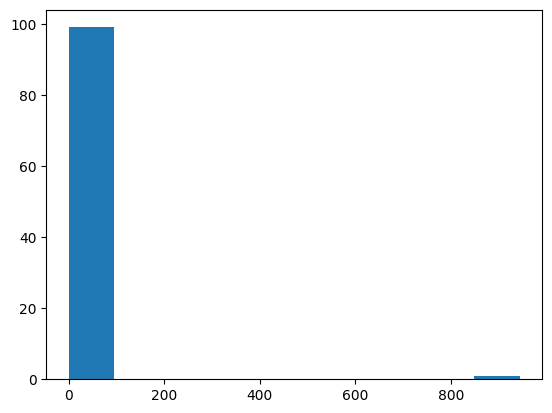

In [ ]:
u = torch.rand(100)

mu, sigma, xi = 0, 1, 1
gpd = mu + sigma * ((1 - u) ** (-xi) - 1) / xi

plt.hist(gpd);

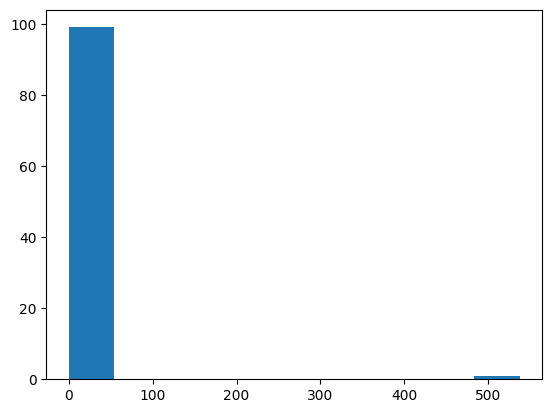

In [ ]:
u = torch.rand(100)
loc, scale, concentration = 0, 1, 1
reparam_gpd = loc + (scale/concentration) * (torch.pow((1-u), -1*concentration) - 1)
plt.hist(reparam_gpd);

[[ 0.6760648   1.2947068   0.9329763  ...  6.4326396   0.7509891
   5.236007  ]
 [ 0.99220335  0.73749495  0.78713477 ...  9.9881735  18.665297
   1.2319652 ]
 [ 0.8765888   2.1303518   0.56296206 ... 21.545395    0.80046105
   4.181732  ]
 ...
 [ 2.107899    0.8164886   1.0233418  ...  8.531589    0.85662943
   1.0743189 ]
 [ 1.1855713   1.8359932   1.7755523  ...  1.0525296   1.2799402
   1.4690654 ]
 [ 1.0840397   1.5969219   1.0633457  ...  0.81574273  1.0921004
   2.2289262 ]]


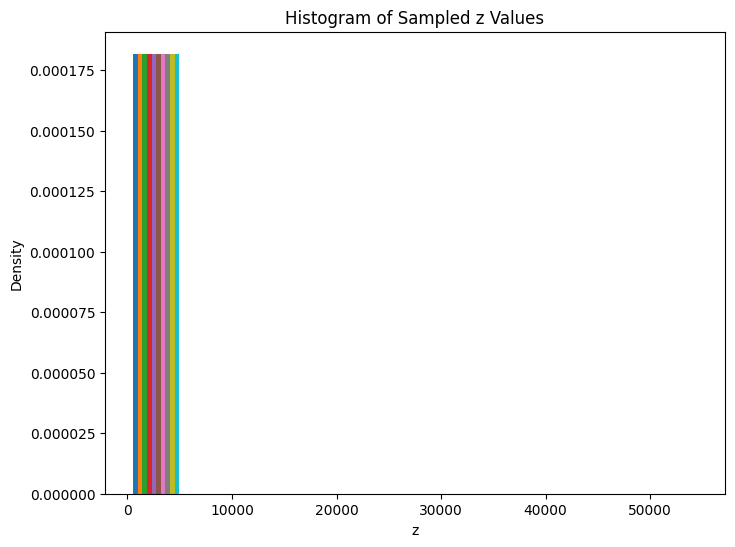

In [ ]:
z_samples = torch.zeros_like(z_pareto_list)
for t in range(loc_z_list.size(1)):
    z_samples[:, t, :] = model.reparameterize_pareto(loc_z_list[:, t, :], scale_z_list[:, t, :], concentration_z_list[:, t, :])

z_samples = z_samples.view(-1, model.latent_size).detach().numpy()
print(z_samples)

plt.figure(figsize=(8, 6))
plt.hist(z_samples, density=True)
plt.xlabel('z')
plt.ylabel('Density')
plt.title('Histogram of Sampled z Values')
plt.show()

# Model

In [ ]:
from ot import wasserstein_1d

class DSVM(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, num_layers, dropout_rate=0.1, recon_loss_vol_weight=1.0):
        super(DSVM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_layers = num_layers
        self.recon_loss_vol_weight = recon_loss_vol_weight

        self.encoder = nn.GRU(input_size=input_size + latent_size + input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.decoder = nn.GRU(input_size=latent_size + input_size + input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # Encoder
        self.encoder_loc = nn.Linear(hidden_size, latent_size)
        self.encoder_scale = nn.Linear(hidden_size, latent_size)
        self.encoder_concentration = nn.Linear(hidden_size, latent_size)

        # Decoder
        self.decoder_out = nn.Linear(hidden_size, input_size)

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, hist_vol):
        batch_size, seq_length, input_size = x.size()
        h_enc = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        h_dec = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        z_prev = torch.ones(batch_size, self.latent_size).to(x.device)
        r_prev = torch.zeros(batch_size, self.input_size).to(x.device)

        z_list = []
        r_list = []

        loc_list = []
        scale_list = []
        z_pareto_list = []
        concentration_list = []

        for t in range(seq_length):
            # Encoder
            encoder_input = torch.cat([x[:, t, :], z_prev, hist_vol], dim=-1)
            _, h_enc = self.encoder(encoder_input.unsqueeze(1), h_enc)
            h_enc = self.dropout(h_enc)

            encoder_loc_z = F.softplus(self.encoder_loc(h_enc[-1])) + 1e-6
            encoder_scale_z = F.softplus(self.encoder_scale(h_enc[-1])) + 1e-6
            encoder_concentration_z = F.softplus(self.encoder_concentration(h_enc[-1])) + 1e-6

            z = self.reparameterize_pareto(encoder_loc_z, encoder_scale_z, encoder_concentration_z)
            z_pareto = self.sample_GeneralizedPareto(encoder_loc_z, encoder_scale_z, encoder_concentration_z)

            z_list.append(z)
            z_pareto_list.append(z_pareto)

            loc_list.append(encoder_loc_z)
            scale_list.append(encoder_scale_z)
            concentration_list.append(encoder_concentration_z)
            z_prev = z

            # Decoder
            decoder_input = torch.cat([z, r_prev, hist_vol], dim=-1)
            _, h_dec = self.decoder(decoder_input.unsqueeze(1), h_dec)
            h_dec = self.dropout(h_dec)
            r = self.decoder_out(h_dec[-1])
            r_list.append(r)
            r_prev = x[:, t, :]

        z_list = torch.stack(z_list, dim=1)  # (batch_size, seq_length, latent_size)
        r_list = torch.stack(r_list, dim=1)  # (batch_size, seq_length, input_size)
        z_pareto_list = torch.stack(z_pareto_list, dim=1)


        loc_z_list = torch.stack(loc_list, dim=1)  # (batch_size, seq_length, latent_size)
        scale_z_list = torch.stack(scale_list, dim=1)  # (batch_size, seq_length, latent_size)
        concentration_z_list = torch.stack(concentration_list, dim=1)  # (batch_size, seq_length, latent_size)

        wasserstein_loss = self.wasserstein_loss(z_list, z_pareto_list)
        recon_loss, recon_loss_vol = self.reconstruction_loss(r_list, x)
        return wasserstein_loss, recon_loss, recon_loss_vol, z_list, r_list, loc_z_list, scale_z_list, concentration_z_list

    def sample_GeneralizedPareto(self, mu, sigma, xi):
            u = torch.rand_like(mu)
            # if xi == 0:
            #     return mu + sigma * torch.log(1 - u)
            # else:
            return mu + sigma * ((1 - u) ** (-xi) - 1) / xi

    def reparameterize_pareto(self, loc, scale, concentration):
        u = torch.rand_like(loc)
        return loc + (scale/concentration) * (torch.pow((1-u), -1*concentration) - 1)

    def wasserstein_loss(self, z_list, prior):
        wasserstein_dist = torch.mean(wasserstein_1d(z_list, prior))
        return wasserstein_dist

    def reconstruction_loss(self, r, x):
        recon_loss_mean = F.mse_loss(r[:, :, :-1], x[:, :, :-1], reduction='sum')
        recon_loss_vol = F.mse_loss(r[:, :, -1], x[:, :, -1], reduction='sum')
        recon_loss = recon_loss_mean + self.recon_loss_vol_weight * recon_loss_vol
        return recon_loss, recon_loss_vol

# Training

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

def preprocess_data(data, seq_length=21, train_ratio=0.75):
    data = data.values
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    data = (data - data_mean) / data_std

    # Calculate historical volatility (e.g., using rolling standard deviation)
    hist_vol = pd.DataFrame(data).rolling(window=seq_length).std().values

    sequences = []
    hist_vols = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(torch.tensor(data[i:i+seq_length], dtype=torch.float32))
        hist_vols.append(torch.tensor(hist_vol[i+seq_length-1], dtype=torch.float32))

    hist_vol = hist_vol[~np.isnan(hist_vol)]

    train_size = int(train_ratio * len(sequences))
    train_sequences = sequences[:train_size]
    train_hist_vols = hist_vols[:train_size]
    test_sequences = sequences[train_size - seq_length:]
    test_hist_vols = hist_vols[train_size - seq_length:]

    train_dataset = TensorDataset(torch.stack(train_sequences), torch.stack(train_hist_vols))
    test_dataset = TensorDataset(torch.stack(test_sequences), torch.stack(test_hist_vols))

    return train_dataset, test_dataset, data_mean, data_std

In [ ]:
seq_length = 10
batch_size = 256
train_dataset, test_dataset, data_mean, data_std = preprocess_data(data, seq_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def train(model, train_loader, optimizer, device=torch.device('cpu'), alpha=0.5, beta=1.0, l1_reg=0.001):
    model.train()
    train_loss = 0
    train_recon_loss = 0
    train_recon_loss_vol = 0
    train_wasserstein_loss = 0

    for batch in train_loader:
        seq_batch, vol_batch = batch
        seq_batch = seq_batch.to(device)

        optimizer.zero_grad()
        wasserstein_loss, recon_loss, recon_loss_vol, z_list, r_list, loc_z_list, scale_z_list, concentration_z_list = model(seq_batch, vol_batch)
        loss = alpha * wasserstein_loss + beta * recon_loss + l1_reg * torch.norm(model.encoder_loc.weight, p=1) + l1_reg * torch.norm(model.encoder_scale.weight, p=1) + l1_reg * torch.norm(model.encoder_concentration.weight, p=1) #* torch.norm(model.encoder_scale.weight, p=1) * torch.norm(model.encoder_concentration.weight, p=1)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_recon_loss_vol += recon_loss_vol.item()
        train_wasserstein_loss += wasserstein_loss.item()

        optimizer.step()

    train_loss /= len(train_loader.dataset)
    train_recon_loss /= len(train_loader.dataset)
    train_recon_loss_vol /= len(train_loader.dataset)
    train_wasserstein_loss /= len(train_loader.dataset)

    return train_loss, train_recon_loss, train_recon_loss_vol, train_wasserstein_loss

def test(model, test_loader, device=torch.device('cpu')):
    model.eval()
    test_loss = 0
    test_recon_loss = 0
    test_recon_loss_vol = 0
    test_wasserstein_loss = 0

    with torch.no_grad():
        for batch in test_loader:
            seq_batch, vol_batch = batch
            seq_batch = seq_batch.to(device)

            wasserstein_loss, recon_loss, recon_loss_vol, z_list, r_list, loc_z_list, scale_z_list, concentration_z_list = model(seq_batch, vol_batch)
            loss = wasserstein_loss + recon_loss

            test_loss += loss.item()
            test_recon_loss += recon_loss.item()
            test_recon_loss_vol += recon_loss_vol.item()
            test_wasserstein_loss += wasserstein_loss.item()

    test_loss /= len(test_loader.dataset)
    test_recon_loss /= len(test_loader.dataset)
    test_recon_loss_vol /= len(test_loader.dataset)
    test_wasserstein_loss /= len(test_loader.dataset)

    return test_loss, test_recon_loss, test_recon_loss_vol, test_wasserstein_loss

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/500], Train Loss: 167.3577, Train Recon Loss: 167.3519, Train Recon Loss Vol: 14.4440, Train Wasserstein Loss: 0.0116, Test Loss: 67.3662, Test Recon Loss: 67.3528, Test Recon Loss Vol: 6.3727, Test Wasserstein Loss: 0.0134
Epoch [20/500], Train Loss: 161.0237, Train Recon Loss: 161.0193, Train Recon Loss Vol: 14.1217, Train Wasserstein Loss: 0.0086, Test Loss: 62.1430, Test Recon Loss: 62.1345, Test Recon Loss Vol: 6.1566, Test Wasserstein Loss: 0.0086
Epoch [30/500], Train Loss: 157.0009, Train Recon Loss: 156.9931, Train Recon Loss Vol: 13.6668, Train Wasserstein Loss: 0.0155, Test Loss: 58.7888, Test Recon Loss: 58.7820, Test Recon Loss Vol: 5.8659, Test Wasserstein Loss: 0.0068
Epoch [40/500], Train Loss: 154.3642, Train Recon Loss: 154.3623, Train Recon Loss Vol: 13.4542, Train Wasserstein Loss: 0.0039, Test Loss: 57.0046, Test Recon Loss: 56.9916, Test Recon Loss Vol: 5.5913, Test Wasserstein Loss: 0.0129
Epoch [50/500], Train Loss: 152.4442, Train Recon Loss: 152.4430

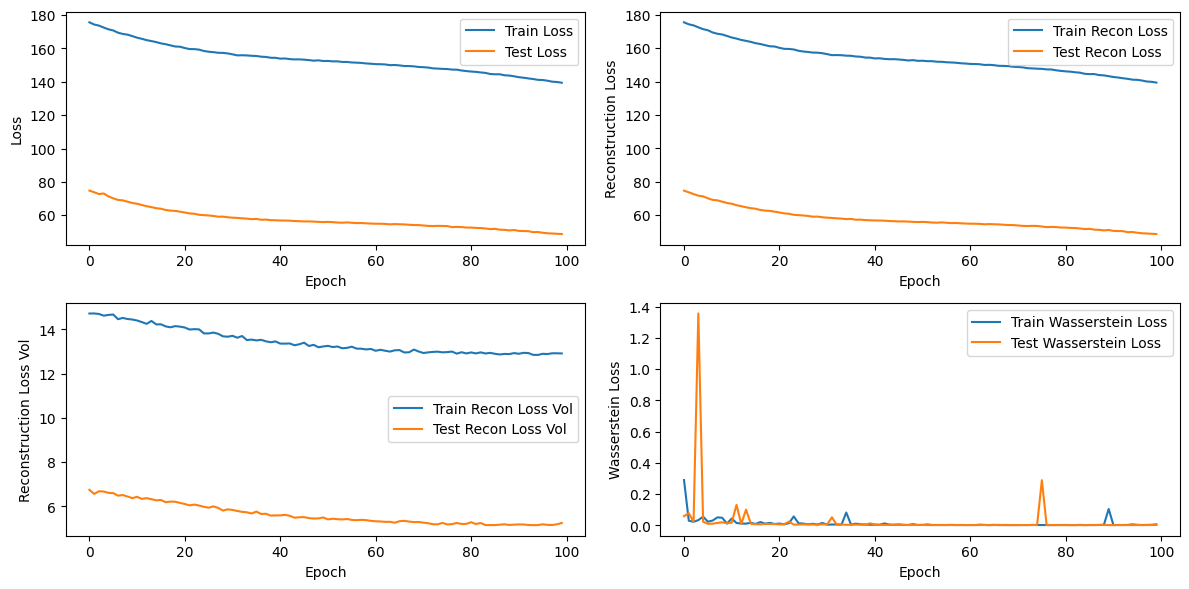

Epoch [110/500], Train Loss: 135.0899, Train Recon Loss: 135.0858, Train Recon Loss Vol: 12.9890, Train Wasserstein Loss: 0.0082, Test Loss: 46.2103, Test Recon Loss: 46.2080, Test Recon Loss Vol: 5.2678, Test Wasserstein Loss: 0.0023
Epoch [120/500], Train Loss: 130.2929, Train Recon Loss: 130.2903, Train Recon Loss Vol: 13.2223, Train Wasserstein Loss: 0.0050, Test Loss: 43.3255, Test Recon Loss: 43.3197, Test Recon Loss Vol: 5.4088, Test Wasserstein Loss: 0.0058
Epoch [130/500], Train Loss: 124.5887, Train Recon Loss: 124.5279, Train Recon Loss Vol: 13.5194, Train Wasserstein Loss: 0.1216, Test Loss: 40.3874, Test Recon Loss: 40.3845, Test Recon Loss Vol: 5.5597, Test Wasserstein Loss: 0.0029
Epoch [140/500], Train Loss: 119.9100, Train Recon Loss: 119.8926, Train Recon Loss Vol: 13.8241, Train Wasserstein Loss: 0.0347, Test Loss: 37.3962, Test Recon Loss: 37.3936, Test Recon Loss Vol: 5.8041, Test Wasserstein Loss: 0.0026
Epoch [150/500], Train Loss: 115.4269, Train Recon Loss: 115

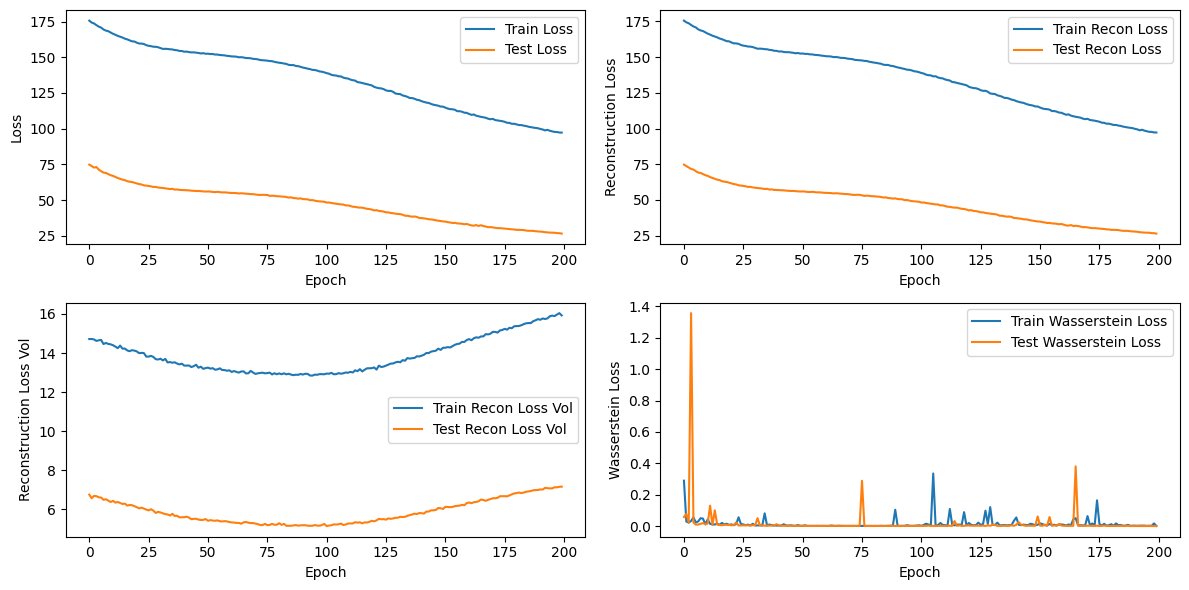

Epoch [210/500], Train Loss: 94.4262, Train Recon Loss: 94.4241, Train Recon Loss Vol: 16.2131, Train Wasserstein Loss: 0.0042, Test Loss: 25.2871, Test Recon Loss: 25.2862, Test Recon Loss Vol: 7.3234, Test Wasserstein Loss: 0.0009
Epoch [220/500], Train Loss: 91.3265, Train Recon Loss: 91.3252, Train Recon Loss Vol: 16.3801, Train Wasserstein Loss: 0.0026, Test Loss: 24.3336, Test Recon Loss: 24.3329, Test Recon Loss Vol: 7.3518, Test Wasserstein Loss: 0.0007
Epoch [230/500], Train Loss: 88.8918, Train Recon Loss: 88.8913, Train Recon Loss Vol: 16.6427, Train Wasserstein Loss: 0.0011, Test Loss: 23.2154, Test Recon Loss: 23.2139, Test Recon Loss Vol: 7.4395, Test Wasserstein Loss: 0.0015
Epoch [240/500], Train Loss: 86.8614, Train Recon Loss: 86.8600, Train Recon Loss Vol: 16.7161, Train Wasserstein Loss: 0.0028, Test Loss: 22.3509, Test Recon Loss: 22.3505, Test Recon Loss Vol: 7.4285, Test Wasserstein Loss: 0.0004
Epoch [250/500], Train Loss: 85.0501, Train Recon Loss: 85.0496, Tra

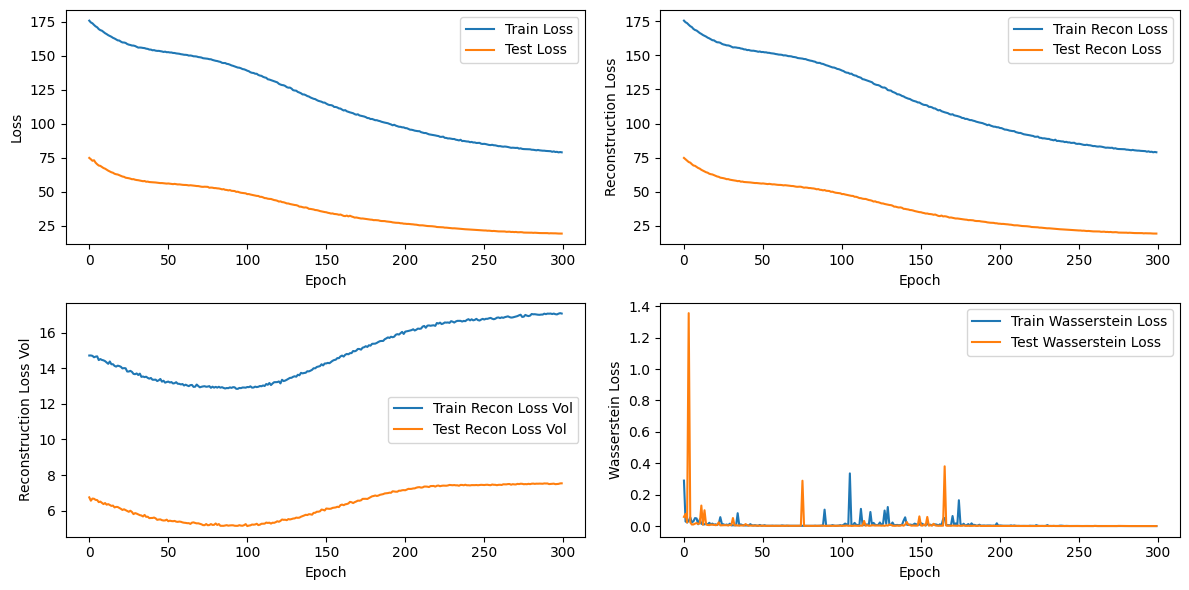

Epoch [310/500], Train Loss: 78.0145, Train Recon Loss: 78.0143, Train Recon Loss Vol: 17.1380, Train Wasserstein Loss: 0.0004, Test Loss: 18.9615, Test Recon Loss: 18.9613, Test Recon Loss Vol: 7.5290, Test Wasserstein Loss: 0.0002
Epoch [320/500], Train Loss: 77.3584, Train Recon Loss: 77.3582, Train Recon Loss Vol: 17.1084, Train Wasserstein Loss: 0.0004, Test Loss: 18.6905, Test Recon Loss: 18.6903, Test Recon Loss Vol: 7.5213, Test Wasserstein Loss: 0.0002
Epoch [330/500], Train Loss: 76.4819, Train Recon Loss: 76.4817, Train Recon Loss Vol: 17.0727, Train Wasserstein Loss: 0.0003, Test Loss: 18.4796, Test Recon Loss: 18.4794, Test Recon Loss Vol: 7.4994, Test Wasserstein Loss: 0.0002
Epoch [340/500], Train Loss: 76.0492, Train Recon Loss: 76.0490, Train Recon Loss Vol: 17.0846, Train Wasserstein Loss: 0.0003, Test Loss: 18.2821, Test Recon Loss: 18.2819, Test Recon Loss Vol: 7.4726, Test Wasserstein Loss: 0.0002
Epoch [350/500], Train Loss: 75.0725, Train Recon Loss: 75.0723, Tra

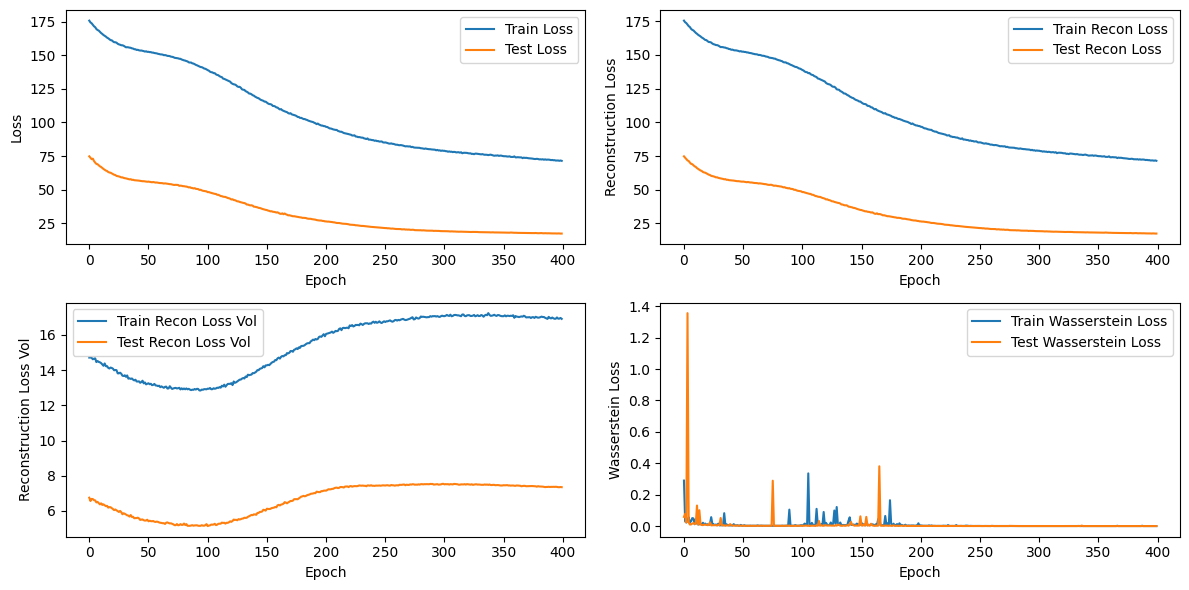

Epoch [410/500], Train Loss: 70.3645, Train Recon Loss: 70.3643, Train Recon Loss Vol: 16.9102, Train Wasserstein Loss: 0.0003, Test Loss: 17.3449, Test Recon Loss: 17.3447, Test Recon Loss Vol: 7.3272, Test Wasserstein Loss: 0.0001
Epoch [420/500], Train Loss: 70.0227, Train Recon Loss: 70.0225, Train Recon Loss Vol: 16.8811, Train Wasserstein Loss: 0.0002, Test Loss: 17.2221, Test Recon Loss: 17.2220, Test Recon Loss Vol: 7.3007, Test Wasserstein Loss: 0.0001
Epoch [430/500], Train Loss: 69.0672, Train Recon Loss: 69.0671, Train Recon Loss Vol: 16.8945, Train Wasserstein Loss: 0.0002, Test Loss: 17.0460, Test Recon Loss: 17.0459, Test Recon Loss Vol: 7.2905, Test Wasserstein Loss: 0.0001
Epoch [440/500], Train Loss: 68.1860, Train Recon Loss: 68.1859, Train Recon Loss Vol: 16.8172, Train Wasserstein Loss: 0.0002, Test Loss: 16.9877, Test Recon Loss: 16.9875, Test Recon Loss Vol: 7.2663, Test Wasserstein Loss: 0.0001
Epoch [450/500], Train Loss: 67.4507, Train Recon Loss: 67.4506, Tra

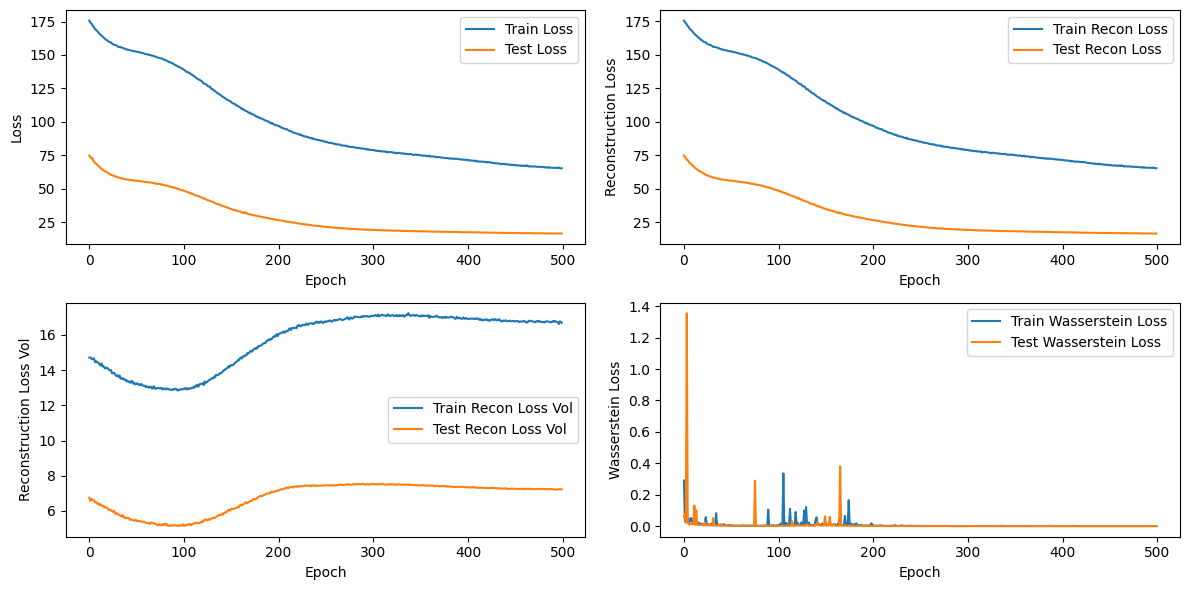

In [ ]:
import os

input_dim = data.shape[1]
latent_dim = 10
hidden_dim = 16
num_layers = 1
learning_rate = 0.0001
epochs = 500
save_interval = 100
plot_interval = 100
decay_rate = 0.96
decay_steps = 500

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DSVM(input_dim, hidden_dim, latent_dim, num_layers, dropout_rate=0.1, recon_loss_vol_weight=0.0).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

save_dir = 'paretoHVVAE_checkpoints'
os.makedirs(save_dir, exist_ok=True)

train_losses = []
test_losses = []
train_recon_losses = []
test_recon_losses = []
train_recon_losses_vol = []
test_recon_losses_vol = []
train_wasserstein_losses = []
test_wasserstein_losses = []

for epoch in trange(1, epochs+1):
    train_loss, train_recon_loss, train_recon_loss_vol, train_wasserstein_loss = train(model, train_loader, optimizer, device, alpha=0.5, beta=1.0, l1_reg=0.0001)
    test_loss, test_recon_loss, test_recon_loss_vol, test_wasserstein_loss = test(model, test_loader, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_recon_losses.append(train_recon_loss)
    test_recon_losses.append(test_recon_loss)
    train_recon_losses_vol.append(train_recon_loss_vol)
    test_recon_losses_vol.append(test_recon_loss_vol)
    train_wasserstein_losses.append(train_wasserstein_loss)
    test_wasserstein_losses.append(test_wasserstein_loss)

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Recon Loss: {train_recon_loss:.4f}, "
              f"Train Recon Loss Vol: {train_recon_loss_vol:.4f}, "
              f"Train Wasserstein Loss: {train_wasserstein_loss:.4f}, "
              f"Test Loss: {test_loss:.4f}, "
              f"Test Recon Loss: {test_recon_loss:.4f}, "
              f"Test Recon Loss Vol: {test_recon_loss_vol:.4f}, "
              f"Test Wasserstein Loss: {test_wasserstein_loss:.4f}")

    if epoch % save_interval == 0:
        torch.save(model.state_dict(), os.path.join(save_dir, f'model_epoch_{epoch}.pth'))

    if epoch % plot_interval == 0:
        plt.figure(figsize=(12, 6))

        plt.subplot(2, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(train_recon_losses, label='Train Recon Loss')
        plt.plot(test_recon_losses, label='Test Recon Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Reconstruction Loss')
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(train_recon_losses_vol, label='Train Recon Loss Vol')
        plt.plot(test_recon_losses_vol, label='Test Recon Loss Vol')
        plt.xlabel('Epoch')
        plt.ylabel('Reconstruction Loss Vol')
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(train_wasserstein_losses, label='Train Wasserstein Loss')
        plt.plot(test_wasserstein_losses, label='Test Wasserstein Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Wasserstein Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    lr = learning_rate * (decay_rate ** (epoch // decay_steps))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Training Plot

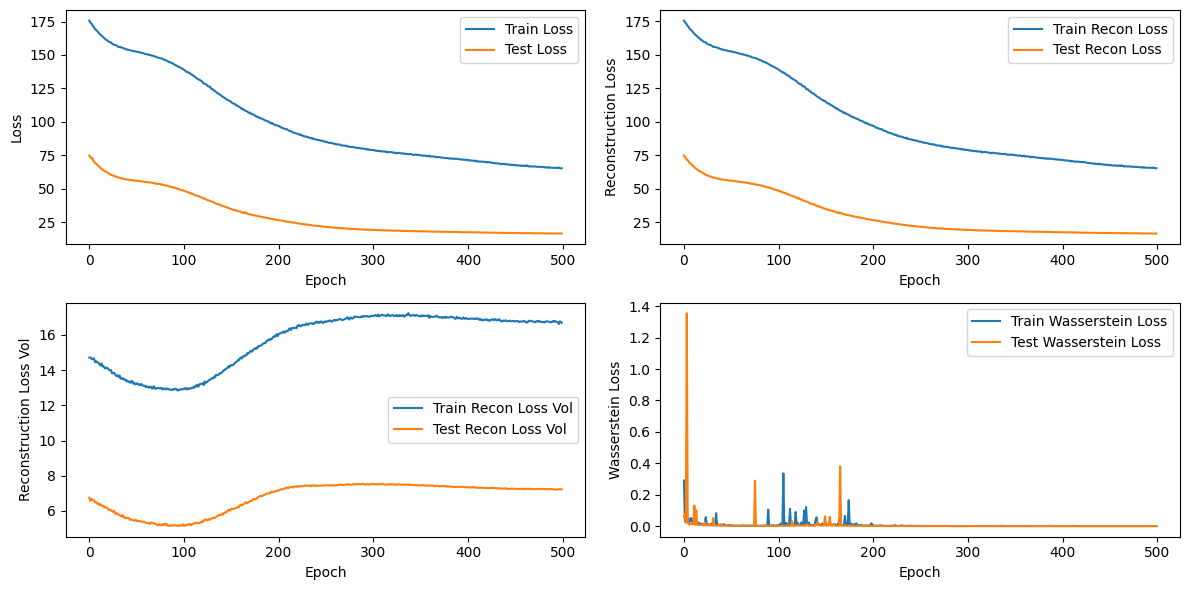

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_recon_losses, label='Train Recon Loss')
plt.plot(test_recon_losses, label='Test Recon Loss')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_recon_losses_vol, label='Train Recon Loss Vol')
plt.plot(test_recon_losses_vol, label='Test Recon Loss Vol')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss Vol')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_wasserstein_losses, label='Train Wasserstein Loss')
plt.plot(test_wasserstein_losses, label='Test Wasserstein Loss')
plt.xlabel('Epoch')
plt.ylabel('Wasserstein Loss')
plt.legend()

plt.tight_layout()
plt.savefig(f"ParetoWassHVVAE_training_plot.png")
plt.show()

# Further training

  0%|          | 0/501 [00:00<?, ?it/s]

Epoch [500/1000], Train Loss: 81.7785, Train Recon Loss: 81.7784, Train Recon Loss Vol: 16.7254, Train Wasserstein Loss: 0.0002, Test Loss: 23.7038, Test Recon Loss: 23.7037, Test Recon Loss Vol: 7.2215, Test Wasserstein Loss: 0.0001


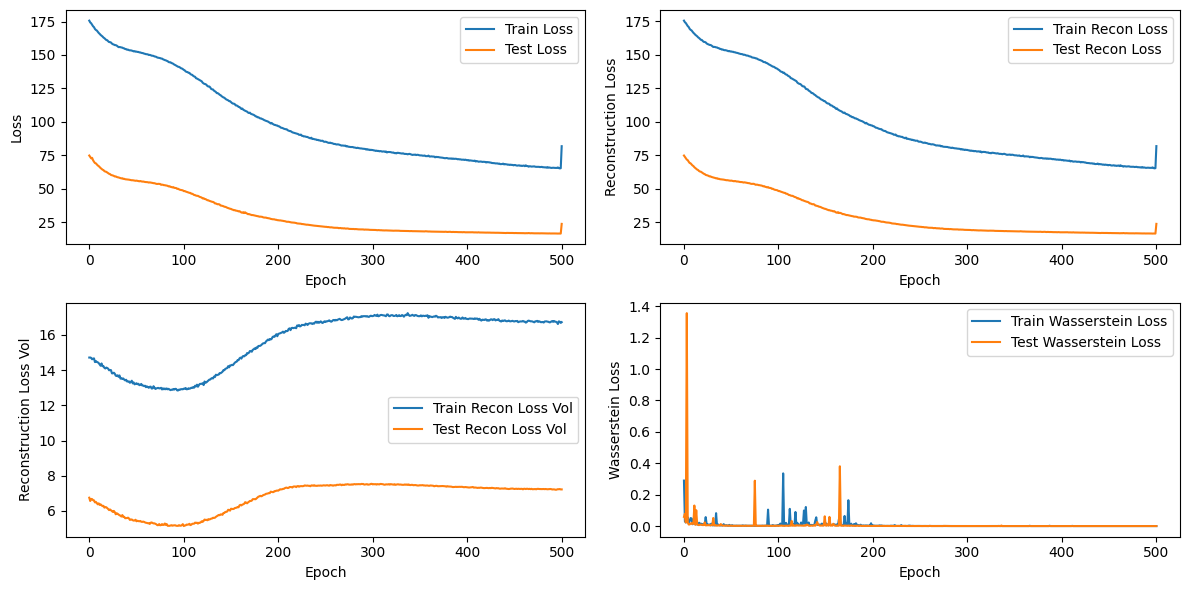

Epoch [510/1000], Train Loss: 81.9083, Train Recon Loss: 81.9082, Train Recon Loss Vol: 16.7232, Train Wasserstein Loss: 0.0002, Test Loss: 23.6949, Test Recon Loss: 23.6948, Test Recon Loss Vol: 7.2178, Test Wasserstein Loss: 0.0001
Epoch [520/1000], Train Loss: 82.1238, Train Recon Loss: 82.1236, Train Recon Loss Vol: 16.7497, Train Wasserstein Loss: 0.0002, Test Loss: 23.6404, Test Recon Loss: 23.6403, Test Recon Loss Vol: 7.2103, Test Wasserstein Loss: 0.0001
Epoch [530/1000], Train Loss: 81.8026, Train Recon Loss: 81.8025, Train Recon Loss Vol: 16.7302, Train Wasserstein Loss: 0.0002, Test Loss: 23.6887, Test Recon Loss: 23.6886, Test Recon Loss Vol: 7.2282, Test Wasserstein Loss: 0.0001
Epoch [540/1000], Train Loss: 82.0359, Train Recon Loss: 82.0358, Train Recon Loss Vol: 16.6683, Train Wasserstein Loss: 0.0002, Test Loss: 23.6796, Test Recon Loss: 23.6795, Test Recon Loss Vol: 7.2166, Test Wasserstein Loss: 0.0001
Epoch [550/1000], Train Loss: 81.7619, Train Recon Loss: 81.7618

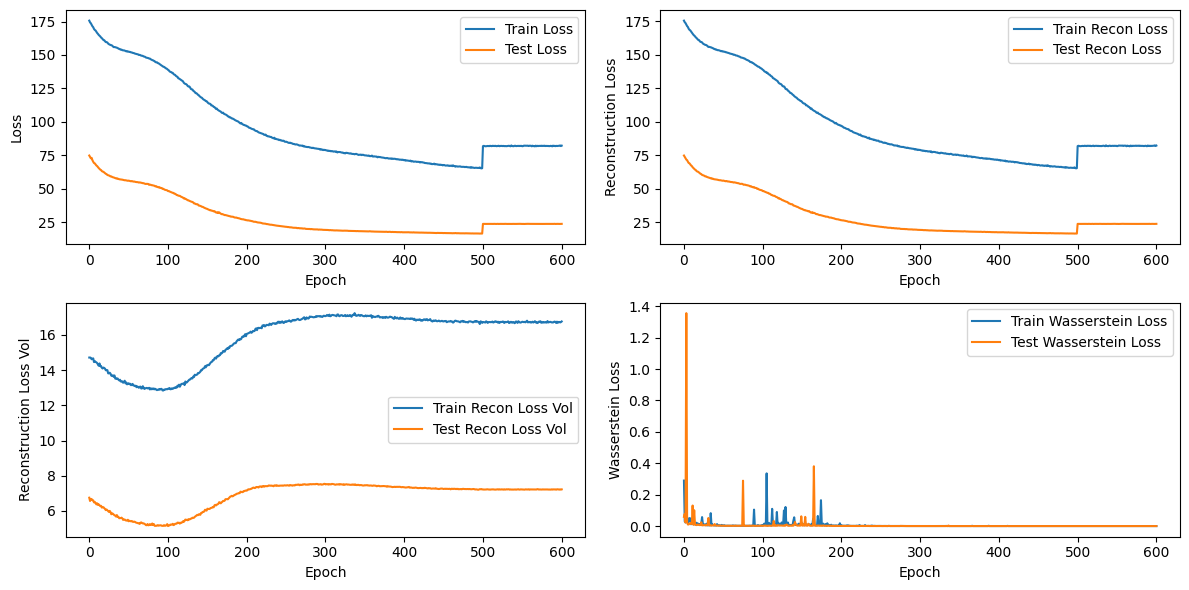

Epoch [610/1000], Train Loss: 81.9674, Train Recon Loss: 81.9672, Train Recon Loss Vol: 16.7147, Train Wasserstein Loss: 0.0004, Test Loss: 23.7062, Test Recon Loss: 23.7062, Test Recon Loss Vol: 7.2300, Test Wasserstein Loss: 0.0001
Epoch [620/1000], Train Loss: 81.7989, Train Recon Loss: 81.7987, Train Recon Loss Vol: 16.6609, Train Wasserstein Loss: 0.0002, Test Loss: 23.6341, Test Recon Loss: 23.6340, Test Recon Loss Vol: 7.2129, Test Wasserstein Loss: 0.0001
Epoch [630/1000], Train Loss: 81.9638, Train Recon Loss: 81.9637, Train Recon Loss Vol: 16.7725, Train Wasserstein Loss: 0.0002, Test Loss: 23.7361, Test Recon Loss: 23.7360, Test Recon Loss Vol: 7.2188, Test Wasserstein Loss: 0.0001
Epoch [640/1000], Train Loss: 82.2226, Train Recon Loss: 82.2225, Train Recon Loss Vol: 16.7308, Train Wasserstein Loss: 0.0002, Test Loss: 23.6816, Test Recon Loss: 23.6815, Test Recon Loss Vol: 7.2195, Test Wasserstein Loss: 0.0001
Epoch [650/1000], Train Loss: 82.0125, Train Recon Loss: 82.0124

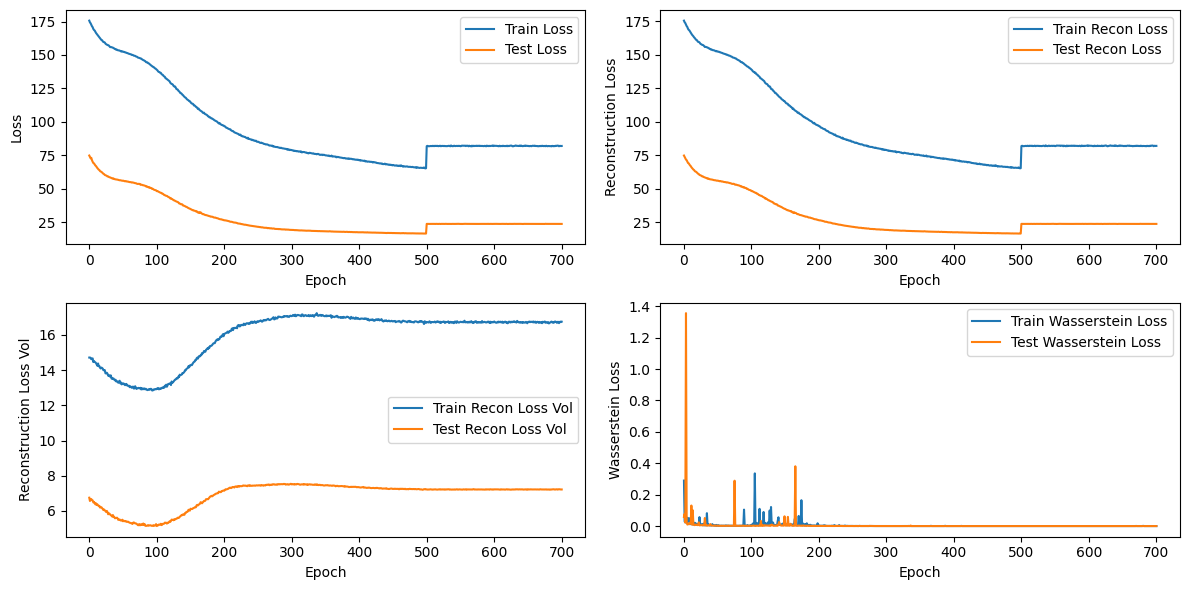

Epoch [710/1000], Train Loss: 81.7957, Train Recon Loss: 81.7956, Train Recon Loss Vol: 16.7428, Train Wasserstein Loss: 0.0002, Test Loss: 23.7350, Test Recon Loss: 23.7349, Test Recon Loss Vol: 7.2204, Test Wasserstein Loss: 0.0001
Epoch [720/1000], Train Loss: 81.8419, Train Recon Loss: 81.8417, Train Recon Loss Vol: 16.7449, Train Wasserstein Loss: 0.0002, Test Loss: 23.6812, Test Recon Loss: 23.6811, Test Recon Loss Vol: 7.2161, Test Wasserstein Loss: 0.0001
Epoch [730/1000], Train Loss: 81.9628, Train Recon Loss: 81.9626, Train Recon Loss Vol: 16.7549, Train Wasserstein Loss: 0.0002, Test Loss: 23.6893, Test Recon Loss: 23.6892, Test Recon Loss Vol: 7.2141, Test Wasserstein Loss: 0.0001
Epoch [740/1000], Train Loss: 81.8704, Train Recon Loss: 81.8703, Train Recon Loss Vol: 16.7074, Train Wasserstein Loss: 0.0002, Test Loss: 23.6760, Test Recon Loss: 23.6759, Test Recon Loss Vol: 7.2236, Test Wasserstein Loss: 0.0001
Epoch [750/1000], Train Loss: 82.0717, Train Recon Loss: 82.0716

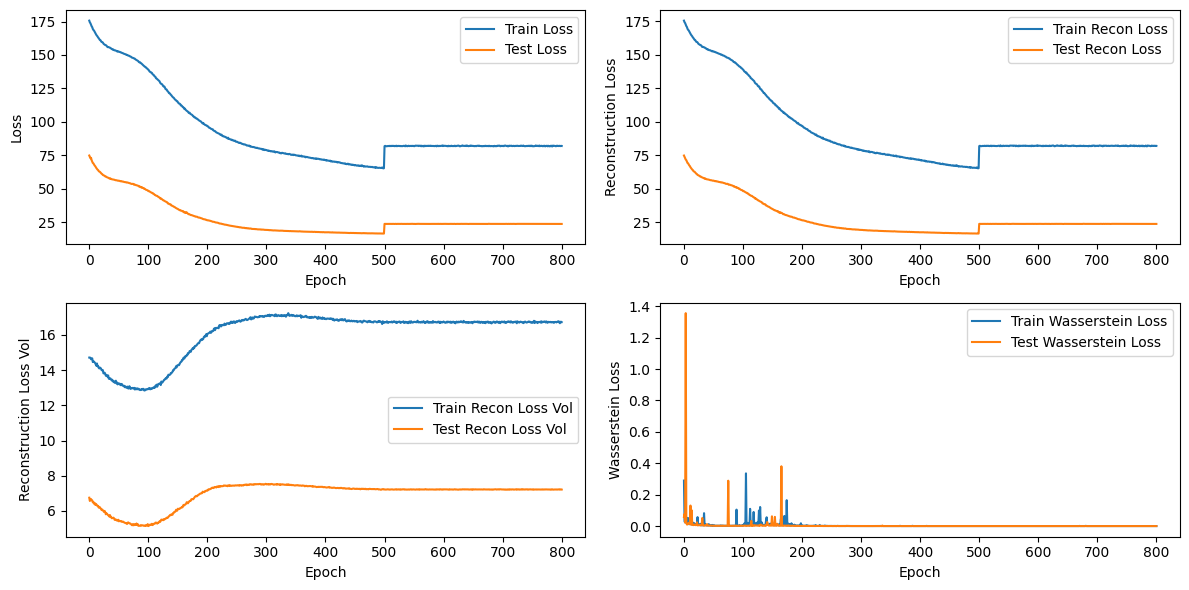

Epoch [810/1000], Train Loss: 81.7952, Train Recon Loss: 81.7950, Train Recon Loss Vol: 16.7077, Train Wasserstein Loss: 0.0002, Test Loss: 23.7148, Test Recon Loss: 23.7147, Test Recon Loss Vol: 7.2105, Test Wasserstein Loss: 0.0001
Epoch [820/1000], Train Loss: 82.0139, Train Recon Loss: 82.0138, Train Recon Loss Vol: 16.7518, Train Wasserstein Loss: 0.0002, Test Loss: 23.7078, Test Recon Loss: 23.7077, Test Recon Loss Vol: 7.2228, Test Wasserstein Loss: 0.0001
Epoch [830/1000], Train Loss: 81.8154, Train Recon Loss: 81.8152, Train Recon Loss Vol: 16.7077, Train Wasserstein Loss: 0.0002, Test Loss: 23.7013, Test Recon Loss: 23.7012, Test Recon Loss Vol: 7.2111, Test Wasserstein Loss: 0.0001
Epoch [840/1000], Train Loss: 81.9791, Train Recon Loss: 81.9789, Train Recon Loss Vol: 16.7445, Train Wasserstein Loss: 0.0004, Test Loss: 23.6384, Test Recon Loss: 23.6383, Test Recon Loss Vol: 7.2138, Test Wasserstein Loss: 0.0001
Epoch [850/1000], Train Loss: 82.0130, Train Recon Loss: 82.0129

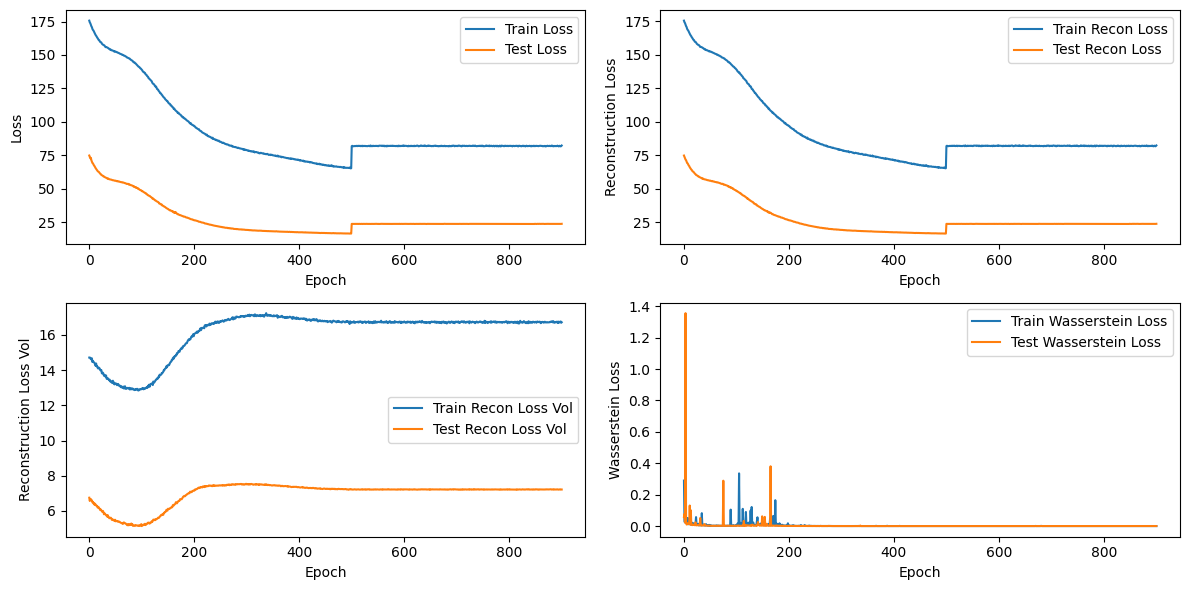

Epoch [910/1000], Train Loss: 81.9385, Train Recon Loss: 81.9383, Train Recon Loss Vol: 16.6977, Train Wasserstein Loss: 0.0002, Test Loss: 23.7170, Test Recon Loss: 23.7169, Test Recon Loss Vol: 7.2252, Test Wasserstein Loss: 0.0001
Epoch [920/1000], Train Loss: 81.9894, Train Recon Loss: 81.9893, Train Recon Loss Vol: 16.7622, Train Wasserstein Loss: 0.0002, Test Loss: 23.7196, Test Recon Loss: 23.7195, Test Recon Loss Vol: 7.2247, Test Wasserstein Loss: 0.0001
Epoch [930/1000], Train Loss: 81.8939, Train Recon Loss: 81.8937, Train Recon Loss Vol: 16.7564, Train Wasserstein Loss: 0.0002, Test Loss: 23.7040, Test Recon Loss: 23.7039, Test Recon Loss Vol: 7.2213, Test Wasserstein Loss: 0.0001
Epoch [940/1000], Train Loss: 81.8392, Train Recon Loss: 81.8390, Train Recon Loss Vol: 16.7341, Train Wasserstein Loss: 0.0003, Test Loss: 23.6942, Test Recon Loss: 23.6941, Test Recon Loss Vol: 7.2197, Test Wasserstein Loss: 0.0001
Epoch [950/1000], Train Loss: 81.9243, Train Recon Loss: 81.9241

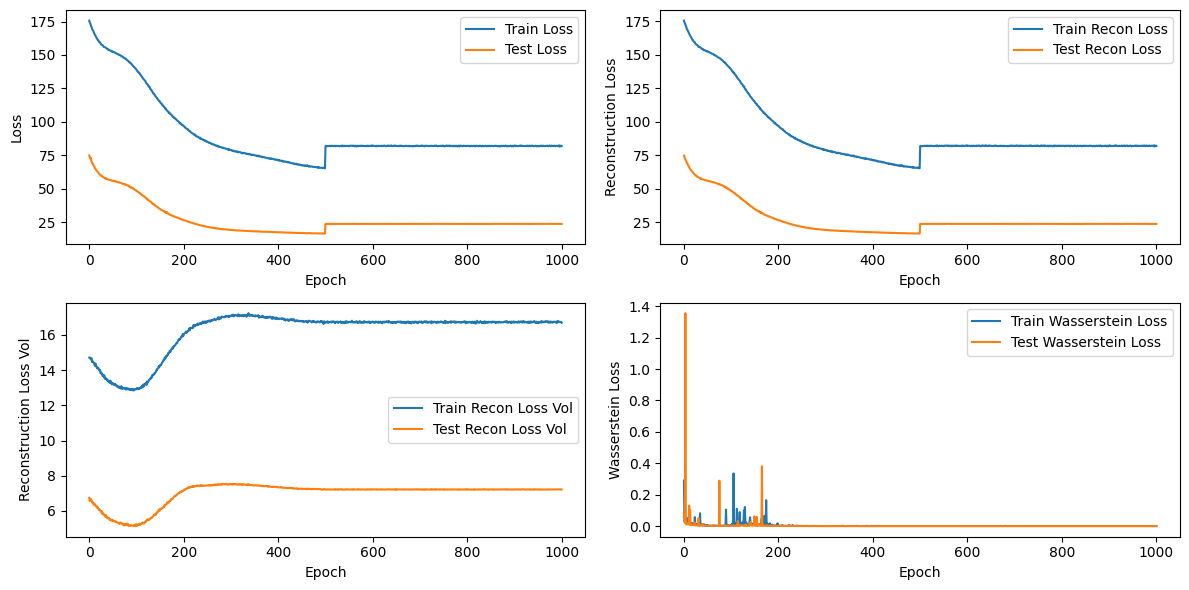

In [ ]:
end_epoch = 500
model = DSVM(input_dim, hidden_dim, latent_dim, num_layers).to(device)
model.load_state_dict(torch.load(save_dir + '/model_epoch_500.pth'))

epochs = 1000

model.train()
for epoch in trange(end_epoch, epochs+1):
    train_loss, train_recon_loss, train_recon_loss_vol, train_wasserstein_loss = train(model, train_loader, optimizer, device, alpha=0.5, beta=1.0, l1_reg=0.0001)
    test_loss, test_recon_loss, test_recon_loss_vol, test_wasserstein_loss = test(model, test_loader, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_recon_losses.append(train_recon_loss)
    test_recon_losses.append(test_recon_loss)
    train_recon_losses_vol.append(train_recon_loss_vol)
    test_recon_losses_vol.append(test_recon_loss_vol)
    train_wasserstein_losses.append(train_wasserstein_loss)
    test_wasserstein_losses.append(test_wasserstein_loss)

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Recon Loss: {train_recon_loss:.4f}, "
              f"Train Recon Loss Vol: {train_recon_loss_vol:.4f}, "
              f"Train Wasserstein Loss: {train_wasserstein_loss:.4f}, "
              f"Test Loss: {test_loss:.4f}, "
              f"Test Recon Loss: {test_recon_loss:.4f}, "
              f"Test Recon Loss Vol: {test_recon_loss_vol:.4f}, "
              f"Test Wasserstein Loss: {test_wasserstein_loss:.4f}")

    if epoch % save_interval == 0:
        torch.save(model.state_dict(), os.path.join(save_dir, f'model_epoch_{epoch}.pth'))

    if epoch % plot_interval == 0:
        plt.figure(figsize=(12, 6))

        plt.subplot(2, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(train_recon_losses, label='Train Recon Loss')
        plt.plot(test_recon_losses, label='Test Recon Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Reconstruction Loss')
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(train_recon_losses_vol, label='Train Recon Loss Vol')
        plt.plot(test_recon_losses_vol, label='Test Recon Loss Vol')
        plt.xlabel('Epoch')
        plt.ylabel('Reconstruction Loss Vol')
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(train_wasserstein_losses, label='Train Wasserstein Loss')
        plt.plot(test_wasserstein_losses, label='Test Wasserstein Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Wasserstein Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    lr = learning_rate * (decay_rate ** (epoch // decay_steps))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Final model

In [ ]:
model = DSVM(input_dim, hidden_dim, latent_dim, num_layers).to(device)
model.load_state_dict(torch.load('/content/deep_var/paretoHVVAE_checkpoints/model_epoch_1000.pth'))

<All keys matched successfully>

In [ ]:
# model.load_state_dict(torch.load('/content/model_epoch_500 (1).pth'))

# Testing randomness

In [ ]:
model.eval()
historical_returns, hist_vol = next(iter(test_loader))
historical_returns = historical_returns.to(device)
hist_vol = hist_vol.to(device)

with torch.no_grad():
     wasserstein_loss, recon_loss, recon_loss_vol, z_list, r_list, loc_z_list, scale_z_list, concentration_z_list = model(historical_returns, hist_vol)

print(f"Input sequence (historical_returns) of {historical_returns.shape}:")
print(historical_returns[0][0])
print(f"Generated r_list of {r_list.shape}:")
print(r_list[0][0])

Input sequence (historical_returns) of torch.Size([256, 10, 13]):
tensor([ 1.8522e+00, -2.8894e-01, -3.7388e-01,  1.0434e-03, -3.6123e-01,
        -1.4449e-01, -5.2565e-01, -5.1718e-01,  8.6074e-02, -2.1663e-02,
         5.8024e-01, -3.2302e-01, -3.6452e-01])
Generated r_list of torch.Size([256, 10, 13]):
tensor([-0.0449, -0.2239, -0.0195, -0.0787, -0.0016, -0.4246, -0.0442, -0.0322,
        -0.1261, -0.3046, -0.0202, -0.1753, -0.0642])


In [ ]:
z_samples = torch.zeros_like(loc_z_list)
for t in range(loc_z_list.size(1)):
    z_samples[:, t, :] = model.reparameterize_pareto(loc_z_list[:, t, :], scale_z_list[:, t, :], concentration_z_list[:, t, :])

z_samples = z_samples.view(-1, model.latent_size).detach().numpy()
print(z_samples)

plt.figure(figsize=(8, 6))
plt.hist(z_samples, density=True)
plt.xlabel('z')
plt.ylabel('Density')
plt.title('Histogram of Sampled z Values')
plt.show();

# VaR Forecasting

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

def preprocess_for_forcast(data, seq_length=21, train_ratio=0.66):
    data = data.values
    data_mean = data.mean(axis=0)

    data_std = data.std(axis=0)
    data = (data - data_mean) / data_std

    # Calculate historical volatility (e.g., using rolling standard deviation)
    hist_vol = pd.DataFrame(data).rolling(window=seq_length).std().values

    sequences = []
    hist_vols = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(torch.tensor(data[i:i+seq_length], dtype=torch.float32))
        hist_vols.append(torch.tensor(hist_vol[i+seq_length-1], dtype=torch.float32))

    hist_vol = hist_vol[~np.isnan(hist_vol)]

    return torch.stack(sequences),  torch.stack(hist_vols), data_std, data_mean

In [ ]:
seq, vol, data_std, data_mean = preprocess_for_forcast(data)

In [ ]:
seq.shape, vol.shape

(torch.Size([2171, 21, 13]), torch.Size([2171, 13]))

In [ ]:
portfolio_weights = torch.tensor(np.array([1/13]*13), dtype=torch.float32, device=device)

In [ ]:
seq_length = 21

In [ ]:
from tqdm import tqdm

In [ ]:
vars = []
actual_values = []
for i in tqdm(range(len(data) - seq_length + 1)):

    historical_returns = seq[i:i+seq_length]
    hist_vol = vol[i:i+seq_length]
    batch_size = 1
    num_samples = 1

    model.eval()
    with torch.no_grad():
        batch_size, seq_length, _ = historical_returns.shape
        h_enc = torch.zeros(model.num_layers, batch_size, model.hidden_size).to(device)
        h_dec = torch.zeros(model.num_layers, batch_size, model.hidden_size).to(device)
        z_prev = torch.ones(batch_size, model.latent_size).to(device)

        for t in range(seq_length):
            encoder_input = torch.cat([historical_returns[:, t, :], z_prev, hist_vol], dim=-1)
            _, h_enc = model.encoder(encoder_input.unsqueeze(1), h_enc)
            encoder_loc_z = F.softplus(model.encoder_loc(h_enc[-1])) + 1e-6
            encoder_scale_z = F.softplus(model.encoder_scale(h_enc[-1])) + 1e-6
            encoder_concentration_z = F.softplus(model.encoder_concentration(h_enc[-1])) + 1e-6

            z_prev = model.reparameterize_pareto(encoder_loc_z, encoder_scale_z, encoder_concentration_z)

        z_samples = []
        for _ in range(1):
            z_sample = model.reparameterize_pareto(encoder_loc_z, encoder_scale_z, encoder_concentration_z)
            z_samples.append(z_sample)
        z_samples = torch.stack(z_samples)

        forecasts = []
        for z_sample in z_samples:
            decoder_input = torch.cat([z_sample, historical_returns[:, -1, :], hist_vol], dim=-1)
            _, h_dec = model.decoder(decoder_input.unsqueeze(1), h_dec)
            forecast = model.decoder_out(h_dec[-1])
            forecasts.append(forecast.squeeze())

        forecasts = torch.stack(forecasts)
        # actual_value = torch.matmul(historical_returns[:, -1, :], portfolio_weights)#.item()
        portfolio_forecasts = torch.matmul(forecasts, portfolio_weights)
        point_forecast = portfolio_forecasts.mean().item()
        lower_quantile = torch.quantile(portfolio_forecasts, 0.01).item()#-max(abs(torch.quantile(portfolio_forecasts, 0.01).item()), abs(torch.quantile(portfolio_forecasts, 0.99).item()))
    vars.append(lower_quantile)
    # actual_values.append(actual_value)
    actual_values.append(torch.matmul(historical_returns[-1, -1, :], portfolio_weights).item())

100%|██████████| 2171/2171 [00:33<00:00, 64.33it/s]


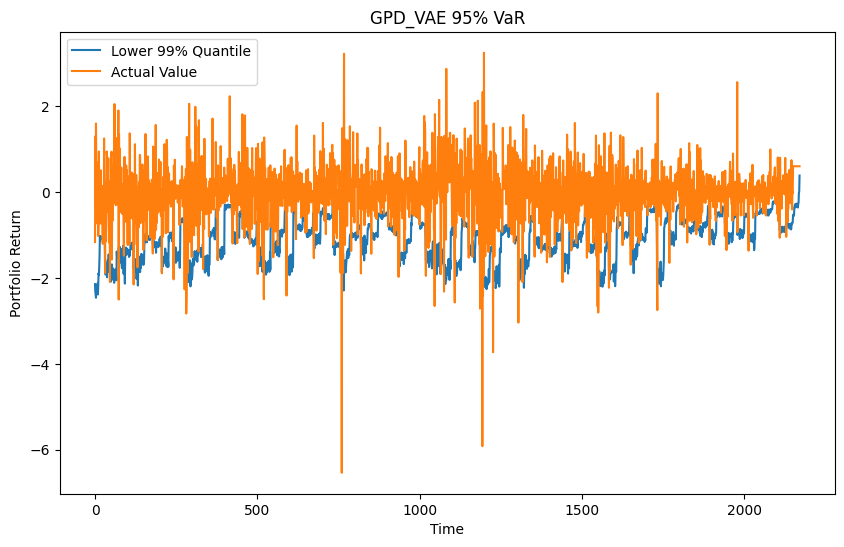

In [ ]:
# Plotting the results

# actual_values = data.dot(portfolio_weights).reset_index(drop=True)
plt.figure(figsize=(10, 6))
plt.plot(vars, label='Lower 99% Quantile')
plt.plot(actual_values, label='Actual Value')
plt.xlabel('Time')
plt.ylabel('Portfolio Return')
plt.title('GPD_VAE 95% VaR')
plt.legend()
plt.savefig(f"GPD_VAE_forecast_plot.png")
plt.show()

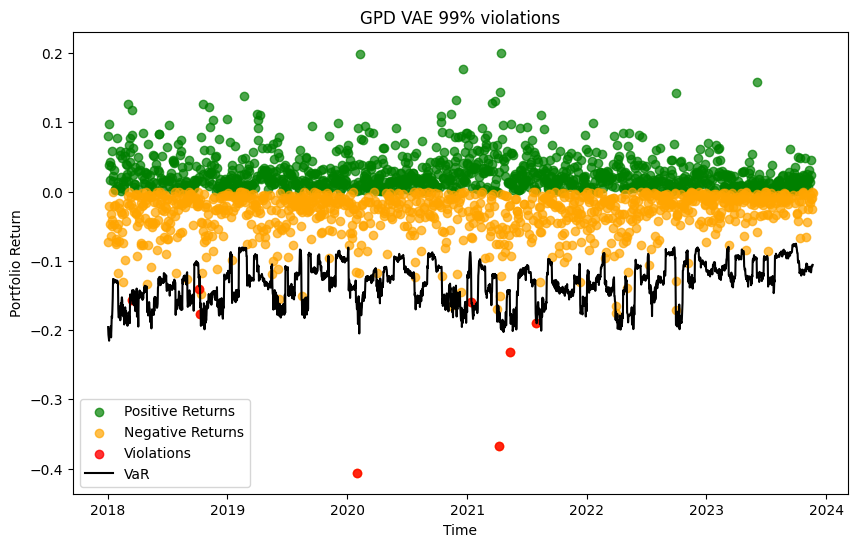

Число пробоев: 8


In [ ]:
lower_quantiles_renorm = np.array(vars) * data_std[-1] + data_mean[-1]
actual_values_renorm = np.array(actual_values) * data_std[-1] + data_mean[-1]

actual_values_renorm = actual_values_renorm[:2150]
lower_quantiles_renorm = lower_quantiles_renorm[:2150]

# Create a DataFrame to store the data
var_df = pd.DataFrame({'Returns': actual_values_renorm, 'VaR': lower_quantiles_renorm}, index=range(len(actual_values_renorm)))

var_df.index = data[:2150].index
# Separate positive and negative returns
pos = var_df[var_df['Returns'] >= 0]
neg = var_df[var_df['Returns'] < 0]

# Calculate violations
var_df['Violation'] = (var_df['Returns'] < var_df['VaR'])
breakdowns = var_df[var_df['Violation'] == True]


# Plot the graph
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(pos.index, pos['Returns'], c='green', alpha=0.7, label='Positive Returns')
plt.scatter(neg.index, neg['Returns'], c='orange', alpha=0.7, label='Negative Returns')
plt.scatter(breakdowns.index, breakdowns['Returns'], c='red', alpha=0.8, label='Violations')
plt.plot(var_df.index, var_df['VaR'], label='VaR', c='black')

plt.legend()
plt.title("GPD VAE 99% violations")
plt.xlabel("Time")
plt.ylabel("Portfolio Return")
plt.savefig(f"ParetoWassHVVAE_breakdown_plot.png")
plt.show()

print('Число пробоев: {}'.format(var_df['Violation'].sum()))

In [ ]:
var_df.to_csv('GPD_VAE_df_upd.csv')

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=21, shuffle=False)
model.eval()

DSVM(
  (encoder): GRU(36, 16, batch_first=True)
  (decoder): GRU(36, 16, batch_first=True)
  (encoder_loc): Linear(in_features=16, out_features=10, bias=True)
  (encoder_scale): Linear(in_features=16, out_features=10, bias=True)
  (encoder_concentration): Linear(in_features=16, out_features=10, bias=True)
  (decoder_out): Linear(in_features=16, out_features=13, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
def one_step_ahead_forecast(model, historical_returns, hist_vol, portfolio_weights, num_samples=1000, device=torch.device('cpu')):
    model.eval()
    with torch.no_grad():
        batch_size, seq_length, _ = historical_returns.shape
        h_enc = torch.zeros(model.num_layers, batch_size, model.hidden_size).to(device)
        h_dec = torch.zeros(model.num_layers, batch_size, model.hidden_size).to(device)
        z_prev = torch.ones(batch_size, model.latent_size).to(device)

        for t in range(seq_length):
            encoder_input = torch.cat([historical_returns[:, t, :], z_prev, hist_vol], dim=-1)
            _, h_enc = model.encoder(encoder_input.unsqueeze(1), h_enc)
            encoder_loc_z = F.softplus(model.encoder_loc(h_enc[-1])) + 1e-6
            encoder_scale_z = F.softplus(model.encoder_scale(h_enc[-1])) + 1e-6
            encoder_concentration_z = F.softplus(model.encoder_concentration(h_enc[-1])) + 1e-6

            z_prev = model.reparameterize_pareto(encoder_loc_z, encoder_scale_z, encoder_concentration_z)

        z_samples = []
        for _ in range(num_samples):
            z_sample = model.reparameterize_pareto(encoder_loc_z, encoder_scale_z, encoder_concentration_z)
            z_samples.append(z_sample)
        z_samples = torch.stack(z_samples)

        forecasts = []
        for z_sample in z_samples:
            decoder_input = torch.cat([z_sample, historical_returns[:, -1, :], hist_vol], dim=-1)
            _, h_dec = model.decoder(decoder_input.unsqueeze(1), h_dec)
            forecast = model.decoder_out(h_dec[-1])
            forecasts.append(forecast.squeeze())

        forecasts = torch.stack(forecasts)
        portfolio_forecasts = torch.matmul(forecasts, portfolio_weights)
        point_forecast = portfolio_forecasts.mean().item()
        lower_quantile = -max(abs(torch.quantile(portfolio_forecasts, 0.01).item()), abs(torch.quantile(portfolio_forecasts, 0.99).item()))

        return point_forecast, lower_quantile, portfolio_forecasts

In [ ]:
from tqdm import tqdm
def generate_forecasts(model, test_loader, portfolio_weights, num_samples =1000, device=torch.device('cpu')):
    model.eval()
    point_forecasts = []
    lower_quantiles = []
    actual_values = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Generating Forecasts"):
            historical_returns, hist_vol = batch
            historical_returns = historical_returns.to(device)
            hist_vol = hist_vol.to(device)

            point_forecast, lower_quantile, portfolio_forecasts = one_step_ahead_forecast(model, historical_returns, hist_vol, portfolio_weights, num_samples, device=device)
            point_forecasts.append(point_forecast)
            lower_quantiles.append(lower_quantile)
            actual_values.append(torch.matmul(historical_returns[:, -1, :], portfolio_weights).item())

    return point_forecasts, lower_quantiles, actual_values, portfolio_forecasts

In [ ]:
from scipy.stats import chi2, norm
def pof_test(var, target, alpha=0.998):
    exception = target < var
    t = len(target)
    m = exception.sum()
    nom = (1 - alpha)**m * alpha**(t-m)
    den = (1 - m/t)**(t - m) * (m / t)**m
    pof_test = -2 * np.log(nom / den)
    pvalue = 1 - chi2.cdf(pof_test, df=1)
    return pvalue

def if_test(var, target):
    exception = target < var
    pairs = [(exception[i], exception[i+1]) for i in range(len(exception) - 1)]
    pairs = np.array(pairs).astype('int')
    n00 = ((pairs[:, 0] == 0) & (pairs[:, 1] == 0)).sum()
    n01 = ((pairs[:, 0] == 0) & (pairs[:, 1] == 1)).sum()
    n10 = ((pairs[:, 0] == 1) & (pairs[:, 1] == 0)).sum()
    n11 = ((pairs[:, 0] == 1) & (pairs[:, 1] == 1)).sum()
    pi = (n01 + n11) / (n00 + n01 + n10 + n11)
    pi0 = n01 / (n00 + n01)
    pi1 = n11 / (n10 + n11)
    nom = (1 - pi)**(n00 + n10) * pi**(n01 + n11)
    den = (1 - pi0)**n00 * pi0**n01 * (1 - pi1)**n10 * pi1**n11
    if_test = -2 * np.log(nom / den)
    pvalue = 1 - chi2.cdf(if_test, df=1)
    return pvalue

def tests(df):
    print("%.2f" % pof_test(df['VaR'], df['Returns']))
    print("%.2f" % if_test(df['VaR'], df['Returns']))

In [ ]:
tests(var_df)